#1 Environment preparation

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
np.random.seed(42)

Linux (colab) settings

In [3]:
sep = "/"
#Edit this to point to project root
home = f"{sep}content{sep}OCR{sep}"

Windows (local) settings

In [4]:
#Edit this to point to project root
sep = "\\"
home = f"B:{sep}Dev{sep}GitHub{sep}University{sep}ThesisMSc{sep}StolenVehicleDetector{sep}Machine Learning{sep}OCR{sep}"

In [5]:
data_dir = f"{home}data{sep}"

model_dir = f"{home}model{sep}"
keras_dir = f"{model_dir}keras{sep}"
tflite_dir = f"{model_dir}tflite{sep}"

In [6]:
#Setup project directories
if not os.path.exists(home):
    os.makedirs(home)

if not os.path.exists(data_dir):
    os.makedirs(data_dir)

if not os.path.exists(model_dir):
    os.makedirs(model_dir)

if not os.path.exists(keras_dir):
    os.makedirs(keras_dir)
    
if not os.path.exists(tflite_dir):
    os.makedirs(tflite_dir)

#2 Dataset

In [7]:
class AbstractDatasetLoader:
    '''Abstract dataset loader class
    '''
    dataset_name = ""
    source_url: str = ""

    def __init__(self, data_dir: str) -> None:
        self.data_dir = data_dir
        self.dataset_dir = self.data_dir + "/" + self.dataset_name
        self.image_IDs = []
        self.labels = []
        self.characters: set = set()
        self.label_max_length: int = 0

    def __download_dataset(self):
        pass

    def __extract_dataset(self):
        pass

    def prepare(self):
        '''Prepare the whole dataset before working with it
        '''
        pass

    def show_info(self):
        '''Show dataset properties
        '''
        print("Number of images: ", len(self.image_IDs))
        print("Number of labels: ", len(self.labels))
        print("Longest label: ", self.label_max_length)
        print("Number of unique characters: ", len(self.characters))
        print("Characters present: ", self.characters)


class CaptchaDatasetLoader(AbstractDatasetLoader):
    '''The captcha dataset loader class
    '''

    dataset_name = "captcha_images_v2"
    source_url: str = "https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip"

    def __init__(self, data_dir: str) -> None:
        super().__init__(data_dir)
        self.download_file_name = self.dataset_dir + ".zip"

    def __download_dataset(self):
        download_file_path = Path(self.download_file_name)
        if not download_file_path.exists():
            #Not yet downloaded
            urllib.request.urlretrieve(self.source_url, download_file_path)

    def __extract_dataset(self):
        download_file_path = Path(self.download_file_name)
        if download_file_path.exists():
            #if the target data directory is empty, extract the zip file
            if not os.listdir(self.data_dir):
                with zipfile.ZipFile(self.download_file_name, 'r') as zip_ref:
                    zip_ref.extractall(path = self.data_dir)

    def load(self):
        '''Loads the whole dataset before working with it
        '''
        # Download & extract dataset if it has not been yet
        self.__download_dataset()
        self.__extract_dataset()

        dataset_path = Path(self.dataset_dir)
        # Get list of the images
        self.image_IDs = sorted(list(map(str, list(dataset_path.glob("*.png")))))
        # Labels of images: image names minus ".png"
        self.labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in self.image_IDs]
        # Set of distinct characters in the labels
        characters = set(char for label in self.labels for char in label)
        self.characters = sorted(characters)
        # Compute the longest label in the dataset
        self.label_max_length = max([len(label) for label in self.labels])

    def split_data(self, train_ratio, shuffle=True):
        # Get the total size of the dataset
        size = len(self.image_IDs)
        # Make an indices array and shuffle it, if required
        indices = np.arange(size)
        if shuffle:
            np.random.shuffle(indices)
        # Get the size of the training samples
        train_samples = int(size * train_ratio)

        images = np.array(self.image_IDs)
        labels = np.array(self.labels)

        # Split data into training and validation sets
        x_train, y_train = images[indices[:train_samples]], images[indices[train_samples:]]
        x_valid, y_valid = labels[indices[:train_samples]], labels[indices[train_samples:]]

        return x_train, x_valid, y_train, y_valid

In [12]:
data_loader = CaptchaDatasetLoader(data_dir)
data_loader.load()
data_loader.show_info()

Number of images:  32
Number of labels:  32
Longest label:  7
Number of unique characters:  19
Characters present:  ['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']


In [13]:
#Training set ratio
train_ratio = 1#0.9
shuffle = True

In [14]:
# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = data_loader.split_data(train_ratio, shuffle)

In [15]:
class DatasetWrapper():

    def __init__(self, characters, image_IDs, labels, image_dim=(200,200), n_channels=3, batch_size=16, shuffle=True, max_block_length=25, oov_token='[?]'):
        self.image_IDs = image_IDs
        # Uniformly transform labels to [0:max_block_length] sized
        self.labels = [label.ljust(max_block_length)[0:max_block_length] for label in labels]
        self.image_dim = image_dim
        self.n_channels = n_channels
        self.shuffle = shuffle

        self.max_block_length = max_block_length
        self.oov_token = oov_token

        self.batch_size = batch_size
        self.num_items = len(self.image_IDs)
        self.num_batches = int(np.floor(self.num_items / self.batch_size))

        # Mapping characters to integers
        self.char_to_num = layers.experimental.preprocessing.StringLookup(
            vocabulary=list(characters), num_oov_indices=1, oov_token=self.oov_token, mask_token=None, invert=False
        )

        # Mapping integers back to characters
        self.num_to_char = layers.experimental.preprocessing.StringLookup(
            vocabulary=self.char_to_num.get_vocabulary(), num_oov_indices=1, oov_token=self.oov_token, mask_token=None, invert=True
        )

        self.dataset = tf.data.Dataset.from_tensor_slices((self.image_IDs, self.labels))
        self.dataset = self.dataset.shuffle(self.num_items, reshuffle_each_iteration=self.shuffle)
        self.dataset = (
            self.dataset.map(
            self.get_item, num_parallel_calls=tf.data.experimental.AUTOTUNE)
            .batch(self.batch_size)
            .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        )

    def data_to_dict(self, image, label):
        # Return a dict
        return {"image": image, "label": label}

    def encode_data(self, img_path, char_label):
        # Read the image
        img = tf.io.read_file(img_path)
        # Decode and convert to have the required amount of channels
        img = tf.io.decode_png(img, channels=self.n_channels)
        # Convert to float32 in [0, 1) range
        img = tf.image.convert_image_dtype(img, tf.float32)
        # Resize to the desired size
        img = tf.image.resize_with_pad(img, self.image_dim[0], self.image_dim[1])
        # keep the characters in the range of [0:self.max_block_length]
        char_label = tf.strings.substr(char_label, 0, self.max_block_length, unit='BYTE', name=None)
        # Splits each string in input into a sequence of Unicode code point
        char_label = tf.strings.unicode_split(char_label, input_encoding="UTF-8")
        # Map the characters in a block to numbers
        num_label = self.char_to_num(char_label)
        # Return the encoded results
        return img, num_label
        
    def get_item(self, img_path, char_label):
        image, label = self.encode_data(img_path, char_label)
        return self.data_to_dict(image, label)

    def decode_image(self, encoded_image):
        # Only one image
        # dimension to correspond to the original order
        #decoded_image = tf.transpose(encoded_image, perm=[1, 0, 2])
        decoded_image = (encoded_image * 255).numpy().astype("uint8")
        return decoded_image

    def decode_label(self, encoded_label, replace_oov):
        # Only one text block
        decoded_label = self.num_to_char(encoded_label)
        decoded_label = tf.strings.reduce_join(decoded_label).numpy().decode("utf-8")
        if replace_oov:
            decoded_label = decoded_label.replace(self.oov_token, '')
        return decoded_label

In [16]:
#Required input image dimensions (N x N images)
img_h = 50
img_w = 200
#3 means RGB, 1 means grayscale
n_channels = 1

In [17]:
#Batch size for training and validation
batch_size = 16 #16
characters = data_loader.characters
#number of characters in the dataset
num_characters = len(data_loader.characters)
max_block_length = 10 #20

In [18]:
print(characters)

['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']


In [19]:
train = DatasetWrapper(characters, x_train, x_valid, image_dim=(img_h, img_w), n_channels=n_channels, 
    batch_size=batch_size, shuffle=True, max_block_length=max_block_length)
    
#validation = DatasetWrapper(characters, y_train, y_valid, image_dim=(img_h, img_w), n_channels=n_channels, 
#    batch_size=batch_size, shuffle=False, max_block_length=max_block_length)
validation = DatasetWrapper(characters, x_train, x_valid, image_dim=(img_h, img_w), n_channels=n_channels, 
    batch_size=batch_size, shuffle=False, max_block_length=max_block_length)

In [20]:
char_to_encode = b'y'

num = train.char_to_num(char_to_encode)
char = train.num_to_char(num)

print(num)
print(char)

tf.Tensor(19, shape=(), dtype=int64)
tf.Tensor(b'y', shape=(), dtype=string)


In [21]:
for batch in train.dataset.take(1):
    labels = batch['label']
    print(labels)

    label_lengths_list = tf.TensorArray(tf.int64, size=len(labels))

    for i in range(len(labels)):
        length = [tf.math.count_nonzero(labels[i])]
        label_lengths_list = label_lengths_list.write(i, length)

    label_lengths = label_lengths_list.stack()
    print(label_lengths)


tf.Tensor(
[[ 1  9 11 13 12  0  0  0  0  0]
 [ 1 13  6 15 14  0  0  0  0  0]
 [ 1  1 16  1 19  7  7  0  0  0]
 [ 1 19  9 15  7  0  0  0  0  0]
 [ 1 12 18 13 10  0  0  0  0  0]
 [ 1 17 18  6  2  0  0  0  0  0]
 [ 1 15  8  9 18  0  0  0  0  0]
 [ 1 13  6  7  2  0  0  0  0  0]
 [ 1 18  6  8 14  0  0  0  0  0]
 [ 1 18  9  1 15  0  0  0  0  0]
 [ 1 14 13  7  6  0  0  0  0  0]
 [12 16 15  0  0  0  0  0  0  0]
 [ 1 17  9  2  7  0  0  0  0  0]
 [ 1 13 19  8  5  0  0  0  0  0]
 [ 1 11 15  6 13  0  0  0  0  0]
 [ 1 15 18  2  7  0  0  0  0  0]], shape=(16, 10), dtype=int64)
tf.Tensor(
[[5]
 [5]
 [7]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [3]
 [5]
 [5]
 [5]
 [5]], shape=(16, 1), dtype=int64)


In [71]:
def show_dataset_sample(dataset_wrapper):
    batch_size = dataset_wrapper.batch_size
    img_in_line = 4
    num_lines = dataset_wrapper.batch_size//img_in_line
    img_size_w = 4
    img_size_h = 2
    _, ax = plt.subplots(num_lines, img_in_line, figsize=(img_in_line*img_size_w, num_lines*img_size_h))
    for batch in dataset_wrapper.dataset.take(1):
        images = batch['image']
        labels = batch['label']
        for i in range(batch_size):
            img = dataset_wrapper.decode_image(images[i])
            label = dataset_wrapper.decode_label(labels[i], True)
            ax[i // img_in_line, i % img_in_line].imshow(img)
            ax[i // img_in_line, i % img_in_line].set_title(label)
    plt.show()

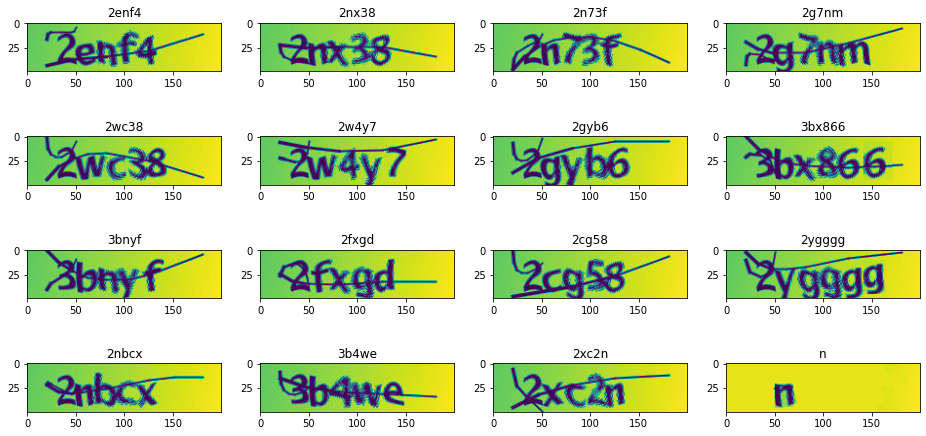

In [72]:
show_dataset_sample(train)

In [22]:
class CTCLayer(layers.Layer):
    
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        ''' 
        y_true: tf.tensor with shape (batch_size, max_len), dtype=int64
        y_pred: tf.tensor with shape (batch_size, max_timesteps, num_characters), dtype=float
        '''

        # Compute the training time loss
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int32")

        label_lengths = tf.TensorArray(tf.int64, size=len(y_true))

        for i in range(batch_len):
            label_length = [tf.math.count_nonzero(y_true[i])]
            label_lengths = label_lengths.write(i, label_length)

        label_lengths = label_lengths.stack()

        pred_lengths = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        pred_lengths = pred_lengths * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, pred_lengths, label_lengths)
        # Add it to the parent layer
        self.add_loss(loss) 

        # At inference, just return the model predictions
        return y_pred

In [23]:
# shape: batch_size x max_len
true = tf.constant(([[1,8,6,3], [1,9,0,0]]), dtype="int64")
# shape: batch_size x max_timesteps x num_characters
pred = tf.zeros(shape=(2, 25, 10), dtype="float")

#ctc = CTCLayer()
#ctc.call(true, pred)

In [24]:
def ocr_model_v1(image_dim: (int, int), channels: int, num_characters: int, optimizer):
    #Factor by which the image is going to be downsampled by the convolutional blocks.
    #Two convolutional blocks are used; each block has a pooling layer which downsample the features by a factor of 2.
    #Thus, the total downsampling factor is (2x2)=4.
    downsample_factor = 4
    #Model inputs
    input_image = layers.Input(shape=(image_dim[0], image_dim[1], channels), name="image", dtype="float32")
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # Make the first dimension correspond to the width of the image
    # RNN part "reads" the image from left to right (instead of top to bottom)
    x = layers.Permute((2, 1, 3), name="Permute")(input_image)

    #1st conv block
    x = layers.Conv2D(32, (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(x)
    #1st max pooling
    x = layers.MaxPooling2D((2, 2), name="Pool1")(x)

    #2nd conv block
    x = layers.Conv2D(64, (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    #2nd max pooling
    x = layers.MaxPooling2D((2, 2), name="MaxPool2")(x)

    # Two max pool have been used with pool size and strides 2.
    # This way, the downsampled feature maps are 4x smaller. 
    # The number of filters in the last layer is 64. 
    # Reshape accordingly before passing the features to the RNN part.
    # image_dim[1], image_dim[0] has reversed order because layers.Permute changed dim 1 & dim 2
    new_shape = ((image_dim[1] // downsample_factor), (image_dim[0] // downsample_factor) * 64)
    x = layers.Reshape(target_shape=new_shape, name="Reshape")(x)
    x = layers.Dense(64, activation="relu", name="Dense1")(x)
    x = layers.Dropout(0.2, name="Dropout")(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25), name="LSTM1")(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25), name="LSTM2")(x)

    # Output layer
    # +1 is for the empty character, +1 is for the 0 padding
    x = layers.Dense(num_characters +1 +1, activation="softmax", name="Dense2")(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="CTCloss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_image, labels], outputs=output, name="ocr_model_v1")
    # Optimizer
    optimizer = optimizer
    # Compile the model
    model.compile(optimizer=optimizer)
    #Return the model to use
    return model

In [25]:
# Create the model
optimizer = keras.optimizers.Adam()
model = ocr_model_v1((img_h, img_w), n_channels, num_characters, optimizer)
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 50, 200, 1)] 0                                            
__________________________________________________________________________________________________
Permute (Permute)               (None, 200, 50, 1)   0           image[0][0]                      
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 200, 50, 32)  320         Permute[0][0]                    
__________________________________________________________________________________________________
Pool1 (MaxPooling2D)            (None, 100, 25, 32)  0           Conv1[0][0]                      
_______________________________________________________________________________________

In [26]:
epochs = 1000
early_stopping_patience = 20

#Early stopping configuration
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

In [27]:
#Train the model
history = model.fit(
    train.dataset,
    validation_data=validation.dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

Epoch 1/1000
2/2 [==============================] - 10s 2s/step - loss: 111.4637 - val_loss: 48.0207
Epoch 2/1000
2/2 [==============================] - 0s 346ms/step - loss: 45.7476 - val_loss: 20.2059
Epoch 3/1000
2/2 [==============================] - 0s 352ms/step - loss: 20.3478 - val_loss: 16.3697
Epoch 4/1000
2/2 [==============================] - 0s 354ms/step - loss: 16.3282 - val_loss: 17.4728
Epoch 5/1000
2/2 [==============================] - 0s 350ms/step - loss: 17.3647 - val_loss: 18.3728
Epoch 6/1000
2/2 [==============================] - 0s 350ms/step - loss: 17.6169 - val_loss: 18.3701
Epoch 7/1000
2/2 [==============================] - 0s 352ms/step - loss: 17.4527 - val_loss: 17.6754
Epoch 8/1000
2/2 [==============================] - 0s 352ms/step - loss: 17.1441 - val_loss: 16.6455
Epoch 9/1000
2/2 [==============================] - 0s 345ms/step - loss: 16.0835 - val_loss: 15.7759
Epoch 10/1000
2/2 [==============================] - 1s 406ms/step - loss: 15.5433 

In [24]:
model.save(f"{keras_dir}model")

INFO:tensorflow:Assets written to: B:\Dev\GitHub\University\ThesisMSc\StolenVehicleDetector\Machine Learning\OCR\model\keras\model\assets


INFO:tensorflow:Assets written to: B:\Dev\GitHub\University\ThesisMSc\StolenVehicleDetector\Machine Learning\OCR\model\keras\model\assets


In [21]:
model = keras.models.load_model(f"{keras_dir}model")

In [83]:
#Get the pure prediction model: extract layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="Dense2").output)
prediction_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 50, 200, 1)]      0         
_________________________________________________________________
Permute (Permute)            (None, 200, 50, 1)        0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 200, 50, 32)       320       
_________________________________________________________________
Pool1 (MaxPooling2D)         (None, 100, 25, 32)       0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 100, 25, 64)       18496     
_________________________________________________________________
MaxPool2 (MaxPooling2D)      (None, 50, 12, 64)        0         
_________________________________________________________________
Reshape (Reshape)            (None, 50, 768)           0   

In [84]:
# A utility function to decode the output of the network
def batch_ctc_decode(preds, max_length):
    input_len = np.ones(preds.shape[0]) * preds.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(preds, input_length=input_len, greedy=True)[0][0][:, :max_length]
    return results

def show_inference_results(dataset_wrapper, model):

    batch_size = dataset_wrapper.batch_size
    img_in_line = 4
    num_lines = dataset_wrapper.batch_size//img_in_line
    img_size_w = 4
    img_size_h = 2

    _, ax = plt.subplots(num_lines, img_in_line, figsize=(img_in_line*img_size_w, num_lines*img_size_h))
    for batch in dataset_wrapper.dataset.take(1):
        images = batch['image']
        labels = batch['label']

        preds = model.predict(images)
        preds = batch_ctc_decode(preds, dataset_wrapper.max_block_length)

        for i in range(batch_size):
            img = dataset_wrapper.decode_image(images[i])
            label = "Truth: " + dataset_wrapper.decode_label(labels[i], True) + "\nPred: " + dataset_wrapper.decode_label(preds[i], True)
            ax[i // img_in_line, i % img_in_line].imshow(img)
            ax[i // img_in_line, i % img_in_line].set_title(label)
    plt.show()

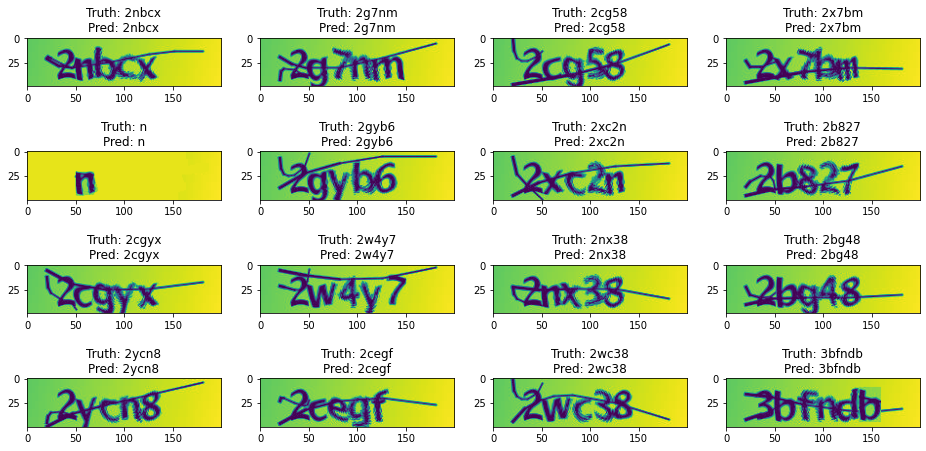

In [89]:
show_inference_results(validation, prediction_model)

In [32]:
def representative_dataset():
    for _ in range(100):
      data = np.random.rand(1, 50, 200, 1)
      yield [data.astype(np.float32)]

In [33]:
converter = tf.lite.TFLiteConverter.from_keras_model(prediction_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter.representative_dataset = representative_dataset
tflite_quant_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\Aaron\AppData\Local\Temp\tmplb8girhl\assets


INFO:tensorflow:Assets written to: C:\Users\Aaron\AppData\Local\Temp\tmplb8girhl\assets


In [ ]:
print(tflite_quant_model.shape)

Error: Kernel is dead

In [ ]:
interpreter = tf.lite.Interpreter(model_content=tflite_quant_model)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

In [ ]:
# Save the model
with open(f"{model_dir}model.tflite", 'wb') as f:
  f.write(tflite_model)

In [ ]:
# Load the TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path=f"{model_dir}model.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print(input_details)
print(output_details)

# Test the model on random input data.
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)